In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, Markdown

# Configuração do estilo dos gráficos
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 10
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10

In [2]:
# Criar um DataFrame de exemplo
dados_exemplo = {
    'Turma': np.random.choice(['Turma A', 'Turma B', 'Turma C'], size=150),
    'Nota_Matematica': np.clip(np.random.normal(loc=6.5, scale=2.5, size=150), 0, 10).round(1),
    'Acesso_Internet': np.random.choice(['Sim', 'Não'], size=150, p=[0.8, 0.2]),
    'Genero': np.random.choice(['Masculino', 'Feminino'], size=150)
}
df_exemplo = pd.DataFrame(dados_exemplo)

# Salvar em um arquivo Excel
arquivo_excel = "notas_alunos.xlsx"
df_exemplo.to_excel(arquivo_excel, index=False)

print(f"Arquivo '{arquivo_excel}' criado com sucesso com {len(df_exemplo)} registros.")

Arquivo 'notas_alunos.xlsx' criado com sucesso com 150 registros.


In [3]:
# 1. LEITURA DE DADOS
def carregar_dados(arquivo):
    """Carrega os dados do arquivo Excel"""
    df = pd.read_excel(arquivo)
    return df

# 2. CÁLCULOS ESTATÍSTICOS
def calcular_estatisticas(df):
    """Calcula estatísticas descritivas para cada turma"""
    estatisticas = {}
    for turma in sorted(df['Turma'].unique()):
        dados_turma = df[df['Turma'] == turma]['Nota_Matematica']
        estatisticas[turma] = {
            'Média': dados_turma.mean(),
            'Mediana': dados_turma.median(),
            'Desvio Padrão': dados_turma.std(),
            'Variância': dados_turma.var(),
            'Amplitude': dados_turma.max() - dados_turma.min(),
            'Mínimo': dados_turma.min(),
            'Máximo': dados_turma.max(),
            'Q1': dados_turma.quantile(0.25),
            'Q3': dados_turma.quantile(0.75),
            'Coef. Variação (%)': (dados_turma.std() / dados_turma.mean()) * 100,
            'Número de Alunos': len(dados_turma)
        }
    return pd.DataFrame(estatisticas).T

# 3. DISTRIBUIÇÃO DE FREQUÊNCIA E CLASSIFICAÇÃO
def criar_distribuicao_frequencia(df, bins=10):
    """Cria tabela de distribuição de frequência e classifica o desempenho"""
    distribuicoes = {}
    classificacoes = {}
    for turma in sorted(df['Turma'].unique()):
        dados_turma = df[df['Turma'] == turma]['Nota_Matematica']
        min_val, max_val = 0, 10
        intervalos = np.linspace(min_val, max_val, bins + 1)
        freq_abs = pd.cut(dados_turma, bins=intervalos, include_lowest=True, right=True).value_counts().sort_index()
        freq_rel = (freq_abs / len(dados_turma)) * 100
        dist_freq = pd.DataFrame({
            'Intervalo': [f"{intervalo.left:.1f} a {intervalo.right:.1f}" for intervalo in freq_abs.index],
            'Frequência Absoluta': freq_abs.values,
            'Frequência Relativa (%)': freq_rel.values.round(2)
        })
        distribuicoes[turma] = dist_freq
              
        classificacao = classificar_desempenho(dist_freq)
              
        classificacoes[turma] = classificacao
        
    return distribuicoes, classificacoes

def classificar_desempenho(dist_freq):
    """Classifica o desempenho da turma com base na tabela de distribuição de frequência."""
    porcentagem_0_4 = dist_freq.loc[dist_freq['Intervalo'].str.contains('^0.0 a|^1.0 a|^2.0 a|^3.0 a'), 'Frequência Relativa (%)'].sum()
    porcentagem_6_10 = dist_freq.loc[dist_freq['Intervalo'].str.contains('^6.0 a|^7.0 a|^8.0 a|^9.0 a'), 'Frequência Relativa (%)'].sum()
    porcentagem_8_10 = dist_freq.loc[dist_freq['Intervalo'].str.contains('^8.0 a|^9.0 a'), 'Frequência Relativa (%)'].sum()
    porcentagem_0_6 = dist_freq.loc[dist_freq['Intervalo'].str.contains('^0.0 a|^1.0 a|^2.0 a|^3.0 a|^4.0 a|^5.0 a'), 'Frequência Relativa (%)'].sum()
    
    resultado = {
        'Porcentagem_6_10': porcentagem_6_10,
        'Porcentagem_0_4': porcentagem_0_4,
        'Porcentagem_8_10': porcentagem_8_10
    }
    
    if porcentagem_6_10 >= 70:
        resultado.update({'Categoria': 'Homogêneo e Suficiente', 'Descrição': f'Mais de 70% dos alunos na faixa de 6,0 a 10,0 ({porcentagem_6_10:.1f}%)'})
    elif porcentagem_0_6 >= 70:
        resultado.update({'Categoria': 'Homogêneo e Insuficiente', 'Descrição': f'Mais de 70% dos alunos na faixa de 0,0 a 6,0 ({porcentagem_0_6:.1f}%)'})
    elif porcentagem_0_4 >= 30 and porcentagem_8_10 >= 30:
        resultado.update({'Categoria': 'Polarizado', 'Descrição': f'Concentrações nas faixas de 0-4 ({porcentagem_0_4:.1f}%) e 8-10 ({porcentagem_8_10:.1f}%)'})
    else:
        resultado.update({'Categoria': 'Heterogêneo', 'Descrição': 'Distribuição dispersa sem padrão claro de concentração'})
        
    return resultado

# 4. VISUALIZAÇÕES (MODIFICADAS PARA EXIBIÇÃO NO NOTEBOOK)
def visualizar_histogramas(df, bins=10):
    turmas = sorted(df['Turma'].unique())
    num_turmas = len(turmas)
    fig, axes = plt.subplots(num_turmas, 1, figsize=(10, 5 * num_turmas), squeeze=False)
    fig.suptitle('Distribuição das Notas de Matemática por Turma', fontsize=16, fontweight='bold')
    colors = sns.color_palette("Set2", num_turmas)
    
    for i, turma in enumerate(turmas):
        dados_turma = df[df['Turma'] == turma]['Nota_Matematica']
        sns.histplot(dados_turma, bins=bins, ax=axes[i, 0], color=colors[i], kde=True)
        axes[i, 0].axvline(dados_turma.mean(), color='red', linestyle='--', linewidth=2, label=f'Média: {dados_turma.mean():.2f}')
        axes[i, 0].axvline(dados_turma.median(), color='green', linestyle=':', linewidth=2, label=f'Mediana: {dados_turma.median():.2f}')
        axes[i, 0].set_title(f'Turma {turma}', fontsize=12, fontweight='bold')
        axes[i, 0].set_xlabel('Nota de Matemática')
        axes[i, 0].set_ylabel('Frequência')
        axes[i, 0].legend()
        axes[i, 0].grid(True, alpha=0.3)
        
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

def visualizar_boxplot_comparativo(df):
    plt.figure(figsize=(8, 6))
    sns.boxplot(data=df, x='Turma', y='Nota_Matematica', palette='Set2')
    plt.title('Comparação das Notas de Matemática entre Turmas', fontsize=14, fontweight='bold')
    plt.xlabel('Turma')
    plt.ylabel('Nota de Matemática')
    plt.grid(True, alpha=0.3)
    plt.show()

def visualizar_barras_estatisticas(estatisticas_df):
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    fig.suptitle('Comparativo de Métricas Estatísticas por Turma', fontsize=16, fontweight='bold')
    
    # Média e Mediana
    estatisticas_df[['Média', 'Mediana']].plot(kind='bar', ax=axes[0, 0], color=['skyblue', 'lightgreen'], rot=0)
    axes[0, 0].set_title('Média e Mediana das Notas')
    axes[0, 0].set_ylabel('Nota')
    axes[0, 0].grid(True, alpha=0.3)
    
    # Desvio Padrão
    estatisticas_df['Desvio Padrão'].plot(kind='bar', ax=axes[0, 1], color='salmon', rot=0)
    axes[0, 1].set_title('Desvio Padrão (Dispersão)')
    axes[0, 1].grid(True, alpha=0.3)
    
    # Amplitude
    estatisticas_df['Amplitude'].plot(kind='bar', ax=axes[1, 0], color='lightseagreen', rot=0)
    axes[1, 0].set_title('Amplitude das Notas (Max - Min)')
    axes[1, 0].set_ylabel('Amplitude')
    axes[1, 0].grid(True, alpha=0.3)
    
    # Coeficiente de Variação
    estatisticas_df['Coef. Variação (%)'].plot(kind='bar', ax=axes[1, 1], color='mediumpurple', rot=0)
    axes[1, 1].set_title('Coeficiente de Variação (%)')
    axes[1, 1].set_ylabel('CV (%)')
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()
    
def visualizar_grafico_classificacao(classificacoes):
    df_class = pd.DataFrame(classificacoes).T
    
    fig, ax = plt.subplots(figsize=(12, 7))
    x = np.arange(len(df_class.index))
    width = 0.25
    
    rects1 = ax.bar(x - width, df_class['Porcentagem_0_4'], width, label='Notas de 0 a 4 (%)', color='lightcoral')
    rects2 = ax.bar(x, df_class['Porcentagem_6_10'], width, label='Notas de 6 a 10 (%)', color='lightgreen')
    rects3 = ax.bar(x + width, df_class['Porcentagem_8_10'], width, label='Notas de 8 a 10 (%)', color='lightblue')
    
    ax.set_ylabel('Porcentagem de Alunos (%)')
    ax.set_title('Classificação de Desempenho por Turma', fontsize=14, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels([f"{turma}\n({cat})" for turma, cat in df_class['Categoria'].items()], rotation=0)
    ax.legend()
    ax.grid(True, alpha=0.3, axis='y')
    
    # Adicionar rótulos nas barras
    ax.bar_label(rects1, padding=3, fmt='%.1f%%')
    ax.bar_label(rects2, padding=3, fmt='%.1f%%')
    ax.bar_label(rects3, padding=3, fmt='%.1f%%')
    
    fig.tight_layout()
    plt.show()

# 5. ANÁLISE ADICIONAL
def analise_acesso_internet(df):
    return df.groupby(['Turma', 'Acesso_Internet'])['Nota_Matematica'].agg(['mean', 'std', 'count']).round(2)

def analise_genero(df):
    df['Genero'] = df['Genero'].str.capitalize()
    return df.groupby(['Turma', 'Genero'])['Nota_Matematica'].agg(['mean', 'std', 'count']).round(2)

In [4]:
# Carregar os dados
df = carregar_dados(arquivo_excel)

# Exibir as primeiras linhas e informações gerais do DataFrame
display(Markdown("### 1. Visualização Inicial dos Dados"))
display(df.head())
display(df.info())

### 1. Visualização Inicial dos Dados

,Turma,Nota_Matematica,Acesso_Internet,Genero
0,Turma B,7.9,Sim,Masculino
1,Turma A,5.1,Sim,Masculino
2,Turma B,7.6,Sim,Masculino
3,Turma A,6.2,Não,Masculino
4,Turma C,3.6,Sim,Feminino


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Turma            150 non-null    object 
 1   Nota_Matematica  150 non-null    float64
 2   Acesso_Internet  150 non-null    object 
 3   Genero           150 non-null    object 
dtypes: float64(1), object(3)
memory usage: 4.8+ KB


None

### 2. Estatísticas Descritivas por Turma

,Média,Mediana,Desvio Padrão,Variância,Amplitude,Mínimo,Máximo,Q1,Q3,Coef. Variação (%),Número de Alunos
Turma A,6.09,5.6,2.15,4.64,7.5,2.5,10.0,4.35,7.45,35.38,47.0
Turma B,6.57,6.9,2.44,5.94,8.7,1.3,10.0,4.90,8.55,37.09,51.0
Turma C,6.69,6.9,2.72,7.41,10.0,0.0,10.0,4.95,9.10,40.68,52.0


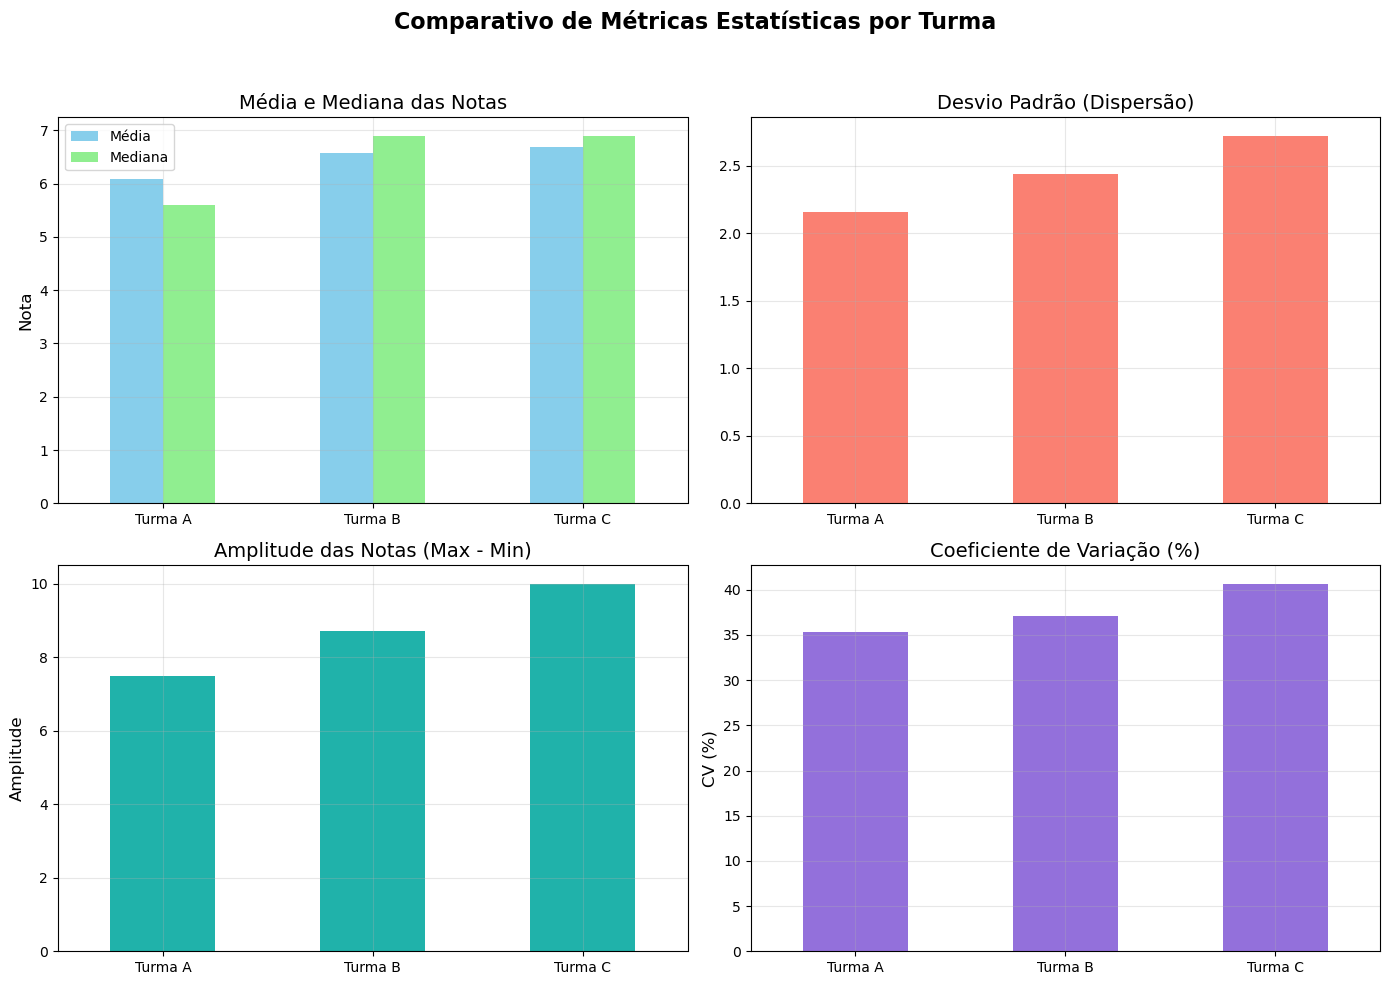

In [5]:
# Calcular e exibir as estatísticas descritivas
display(Markdown("### 2. Estatísticas Descritivas por Turma"))
estatisticas_df = calcular_estatisticas(df)
display(estatisticas_df.round(2))

# Visualizar o gráfico comparativo das estatísticas
visualizar_barras_estatisticas(estatisticas_df)

### 3. Distribuição de Frequência e Classificação do Desempenho

#### Tabela de Frequência - Turma A

,Intervalo,Frequência Absoluta,Frequência Relativa (%)
0,-0.0 a 1.0,0,0.00
1,1.0 a 2.0,0,0.00
2,2.0 a 3.0,1,2.13
3,3.0 a 4.0,7,14.89
4,4.0 a 5.0,12,25.53
5,5.0 a 6.0,7,14.89
6,6.0 a 7.0,6,12.77
7,7.0 a 8.0,4,8.51
8,8.0 a 9.0,3,6.38
9,9.0 a 10.0,7,14.89


#### Tabela de Frequência - Turma B

,Intervalo,Frequência Absoluta,Frequência Relativa (%)
0,-0.0 a 1.0,0,0.00
1,1.0 a 2.0,2,3.92
2,2.0 a 3.0,2,3.92
3,3.0 a 4.0,4,7.84
4,4.0 a 5.0,9,17.65
5,5.0 a 6.0,4,7.84
6,6.0 a 7.0,5,9.80
7,7.0 a 8.0,10,19.61
8,8.0 a 9.0,6,11.76
9,9.0 a 10.0,9,17.65


#### Tabela de Frequência - Turma C

,Intervalo,Frequência Absoluta,Frequência Relativa (%)
0,-0.0 a 1.0,3,5.77
1,1.0 a 2.0,0,0.00
2,2.0 a 3.0,2,3.85
3,3.0 a 4.0,4,7.69
4,4.0 a 5.0,5,9.62
5,5.0 a 6.0,4,7.69
6,6.0 a 7.0,9,17.31
7,7.0 a 8.0,7,13.46
8,8.0 a 9.0,5,9.62
9,9.0 a 10.0,13,25.00


#### Tabela Resumo da Classificação

,Categoria,Descrição
Turma A,Heterogêneo,Distribuição dispersa sem padrão claro de conc...
Turma B,Heterogêneo,Distribuição dispersa sem padrão claro de conc...
Turma C,Heterogêneo,Distribuição dispersa sem padrão claro de conc...


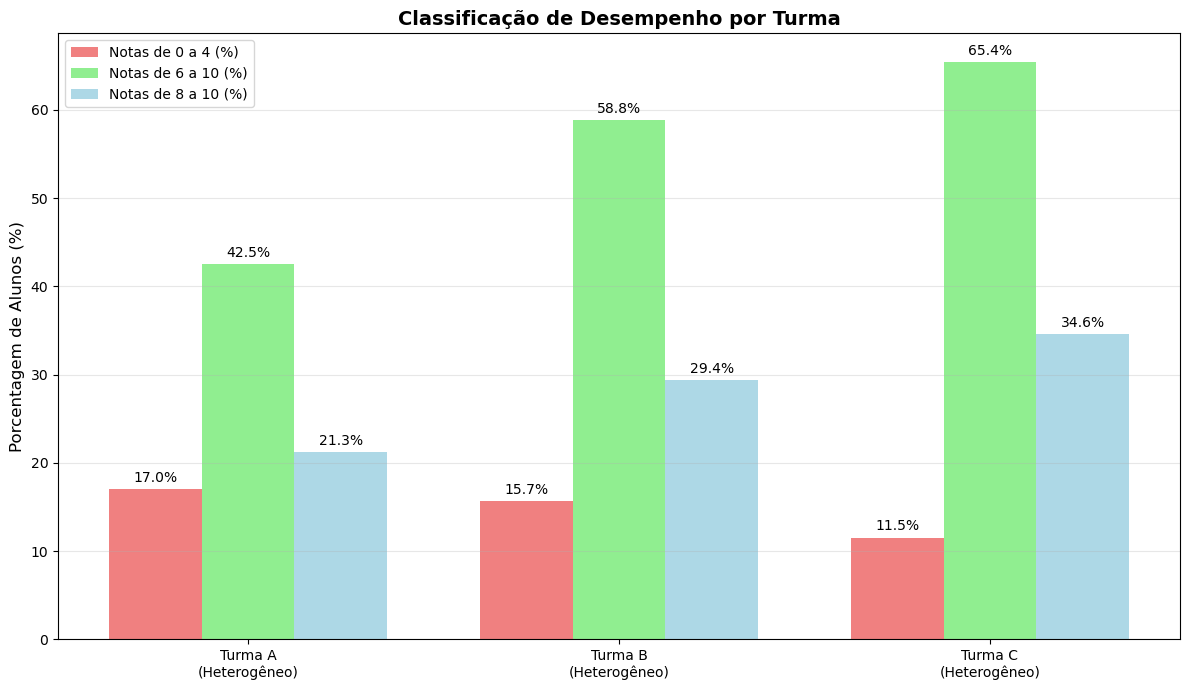

In [6]:
# Criar e exibir as tabelas de distribuição de frequência
display(Markdown("### 3. Distribuição de Frequência e Classificação do Desempenho"))
distribuicoes, classificacoes = criar_distribuicao_frequencia(df)

for turma, tabela in distribuicoes.items():
    display(Markdown(f"#### Tabela de Frequência - {turma}"))
    display(tabela)

# Exibir a classificação consolidada
display(Markdown("#### Tabela Resumo da Classificação"))
df_classificacoes = pd.DataFrame(classificacoes).T
display(df_classificacoes[['Categoria', 'Descrição']])

# Visualizar o gráfico de classificação
visualizar_grafico_classificacao(classificacoes)

### 4. Visualizações da Distribuição das Notas

C:\Users\vitor\AppData\Local\Temp\ipykernel_16948\2088505551.py:100: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Turma', y='Nota_Matematica', palette='Set2')


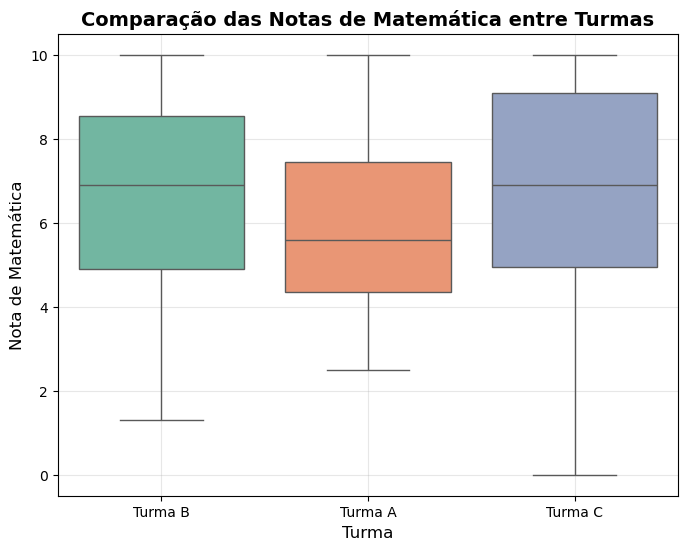

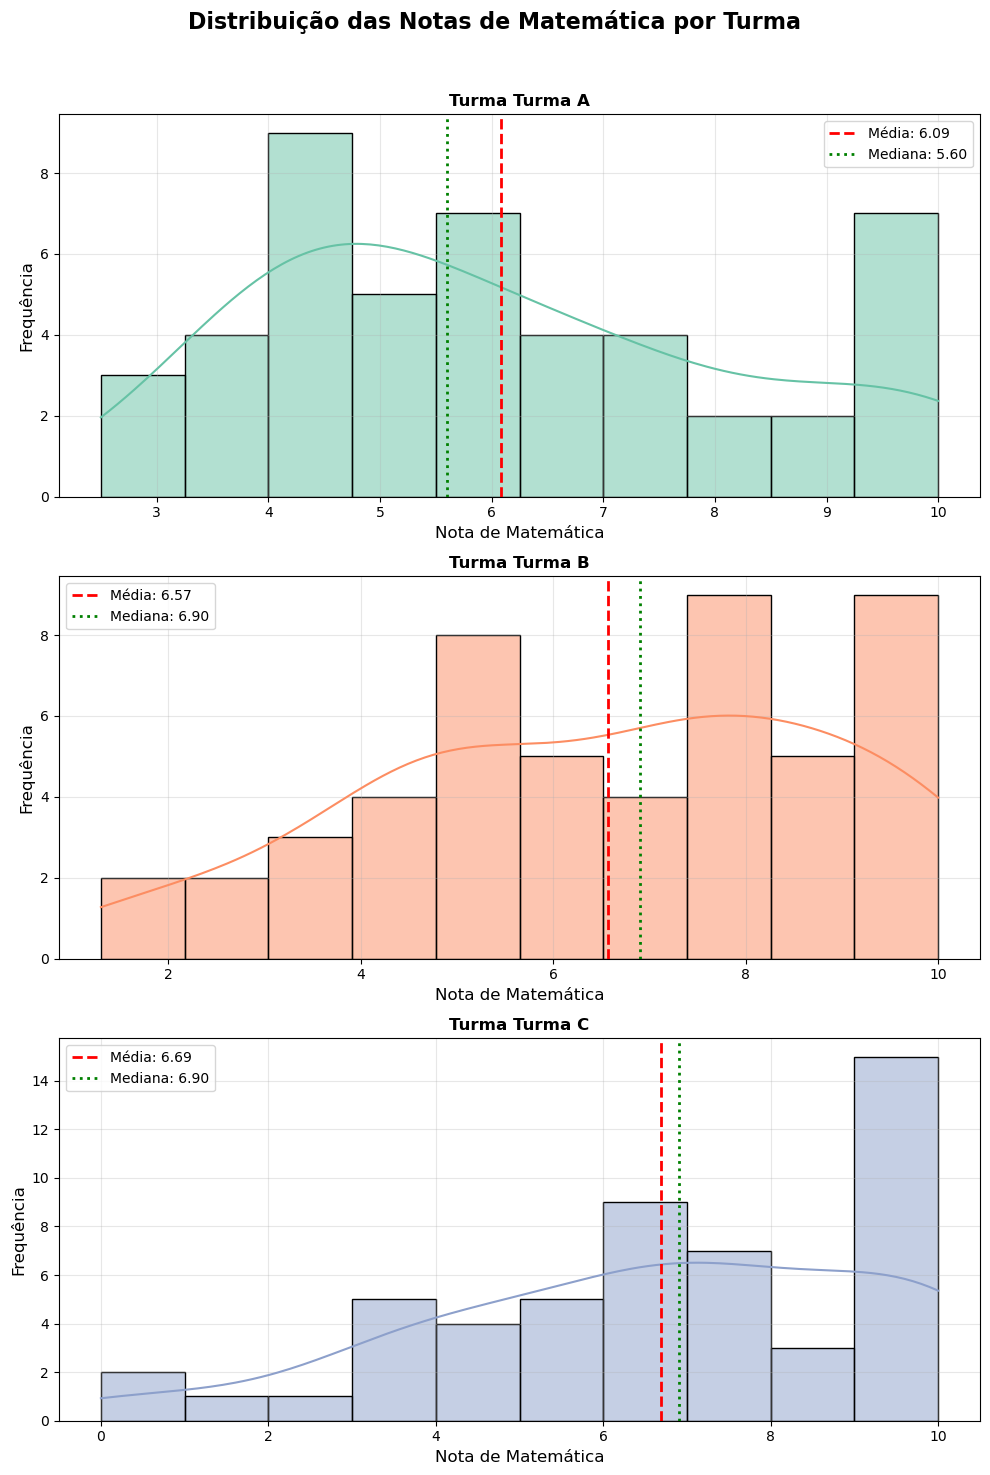

In [7]:
display(Markdown("### 4. Visualizações da Distribuição das Notas"))

# Visualizar boxplot comparativo
visualizar_boxplot_comparativo(df)

# Visualizar histogramas de cada turma
visualizar_histogramas(df)

In [8]:
display(Markdown("### 5. Análises Adicionais"))

# Análise por acesso à internet
display(Markdown("#### Desempenho por Acesso à Internet"))
stats_internet = analise_acesso_internet(df)
display(stats_internet)

# Análise por gênero
display(Markdown("#### Desempenho por Gênero"))
stats_genero = analise_genero(df)
display(stats_genero)

### 5. Análises Adicionais

#### Desempenho por Acesso à Internet

mean   std  count
Turma   Acesso_Internet                   
Turma A Não              6.47  2.53      9
        Sim              6.00  2.08     38
Turma B Não              6.29  2.84      9
        Sim              6.63  2.38     42
Turma C Não              6.78  2.24     13
        Sim              6.66  2.89     39

#### Desempenho por Gênero

mean   std  count
Turma   Genero                      
Turma A Feminino   6.07  2.06     22
        Masculino  6.10  2.28     25
Turma B Feminino   5.86  2.32     20
        Masculino  7.03  2.44     31
Turma C Feminino   6.78  3.02     26
        Masculino  6.60  2.45     26

In [9]:
display(Markdown("### 6. Insights e Recomendações"))

for turma, classificacao in classificacoes.items():
    categoria = classificacao['Categoria']
    display(Markdown(f"**🎯 TURMA {turma} - {categoria}**"))
    
    if categoria == 'Homogêneo e Suficiente':
        print("  ✅ Excelente desempenho coletivo. A maioria dos alunos demonstra domínio do conteúdo.")
        print("  💡 Recomendações: Manter as estratégias atuais e introduzir tópicos avançados ou projetos para desafiar os alunos com melhor desempenho.")
    elif categoria == 'Homogêneo e Insuficiente':
        print("  ⚠️ Desempenho geral abaixo do esperado, indicando dificuldades conceituais na maior parte da turma.")
        print("  💡 Recomendações: Revisão intensiva dos conceitos fundamentais, aulas de reforço, atividades práticas e acompanhamento próximo do progresso.")
    elif categoria == 'Polarizado':
        print("  🔄 Grande disparidade de desempenho, com um grupo de alunos com ótimo rendimento e outro com muitas dificuldades.")
        print("  💡 Recomendações: Implementar a diferenciação pedagógica, com atividades distintas para cada grupo. Criar grupos de tutoria entre pares e projetos em grupo que valorizem diferentes habilidades.")
    else: # Heterogêneo
        print("  📊 Desempenho variado entre os alunos, sem uma concentração clara em nenhuma faixa de nota.")
        print("  💡 Recomendações: Monitoramento contínuo para identificar padrões emergentes. Flexibilizar as estratégias de ensino para atender a diferentes ritmos de aprendizagem.")
    print("-" * 50)

### 6. Insights e Recomendações

**🎯 TURMA Turma A - Heterogêneo**

  📊 Desempenho variado entre os alunos, sem uma concentração clara em nenhuma faixa de nota.
  💡 Recomendações: Monitoramento contínuo para identificar padrões emergentes. Flexibilizar as estratégias de ensino para atender a diferentes ritmos de aprendizagem.
--------------------------------------------------


**🎯 TURMA Turma B - Heterogêneo**

  📊 Desempenho variado entre os alunos, sem uma concentração clara em nenhuma faixa de nota.
  💡 Recomendações: Monitoramento contínuo para identificar padrões emergentes. Flexibilizar as estratégias de ensino para atender a diferentes ritmos de aprendizagem.
--------------------------------------------------


**🎯 TURMA Turma C - Heterogêneo**

  📊 Desempenho variado entre os alunos, sem uma concentração clara em nenhuma faixa de nota.
  💡 Recomendações: Monitoramento contínuo para identificar padrões emergentes. Flexibilizar as estratégias de ensino para atender a diferentes ritmos de aprendizagem.
--------------------------------------------------
